In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/MyDrive/Term 8/Term 8 Artificial Intelligence/folder
# %cd /content/drive/MyDrive/CellCount

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/CellCount-main')

In [ ]:
!git clone https://github.com/Bjarten/early-stopping-pytorch.git ./earlystopping

fatal: destination path './earlystopping' already exists and is not an empty directory.


In [ ]:
import os
import torch
import datetime
from model import *
from utils import *
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage import io
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from scipy.io import loadmat, savemat
from torch.utils.data import Dataset, DataLoader
from earlystopping.pytorchtools import EarlyStopping
from torch.utils.data.sampler import SubsetRandomSampler

# Dataset and Dataloader

In [ ]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

class CellDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fileNames)
    
    """
    returns: tuple of
    - image
    - mask of size n x n with unique values/classes ranging from 0 to 4 
        0: background
        1: others (1)
        2: inflammatory(2)
        3: healthy epithelial(3) , dysplastic/malignant epithelial(4)
        4: fibroblast(5) , muscle(6) , endothelial(7)
    """
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,"Images",self.fileNames[idx])+".png"
        image = img = Image.open(img_name).convert('RGB')
        mask_name = os.path.join(self.root_dir,"Labels",self.fileNames[idx])+".mat"
        x = loadmat(mask_name)['type_map']
        x[(x==3)|(x==4)]=3
        x[(x==5)|(x==6)|(x==7)]=4
        
        # 250x250 images
        # x=np.pad(x.astype(int),3)

        # 500x500 images
        x=np.pad(x.astype(int),6)

        # 1000x1000 images
        # x=np.pad(x.astype(int),12)

        if self.transform:
            image = self.transform(image)
        return image, to_categorical(x,5).transpose(2, 0, 1) #(num_classes=5, n, n)

In [ ]:
transform = transforms.Compose([
    # 250x250 images
    # transforms.Pad(3),

    # 500x500 images
    transforms.Pad(6),

    # 1000x1000 images
    # transforms.Pad(12),
    
    transforms.ToTensor()    
])

valid_size = 0.2
batch_size =1

# DataLoader
train_data = CellDataset(root_dir="/content/drive/MyDrive/CellCount-main/train_500", transform = transform)
test_data = CellDataset(root_dir="/content/drive/MyDrive/CellCount-main/test_500", transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# load training data in batches
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=train_sampler,
                          num_workers=0)

# load validation data in batches
valid_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=valid_sampler,
                          num_workers=0)

# load test data in batches
test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        num_workers=0)

## Training

In [ ]:
def weighted_loss(pred,targ,bce_weight=0.7, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss

def train(model, device, train_loader, valid_loader, optimizer, epochs, patience, model_chkpt_name):
    train_losses = []
    valid_losses = []
    avg_train_losses = [] # average training loss per epoch
    avg_valid_losses = [] # average validation loss per epoch
    valid_acc = 0
    
    os.makedirs("/content/drive/MyDrive/CellCount-main/best_model_checkpoints", exist_ok=True)
    os.makedirs("/content/drive/MyDrive/CellCount-main/model_checkpoints", exist_ok=True)
    save_path = f"/content/drive/MyDrive/CellCount-main/best_model_checkpoints/{model.__class__.__name__}.pth"
    early_stopping = EarlyStopping(patience=patience, path=save_path, verbose=True)
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
        valid_loss = 0
        score = 0
        """
        Trains the model on training data
        """
        for batch_idx, (data, target) in enumerate(train_loader):
            model.train()
            data, target = data.to(device), target.to(device).float()

            optimizer.zero_grad()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.5) 
            loss.backward()
            optimizer.step()

            train_loss+=(loss/len(data)).item()
            train_losses.append(loss.item())
            # Find accuracy
        
        """
        Validate the model on validation data
        """
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device).float()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.3)
            valid_loss+=(loss/len(data)).item()
            valid_losses.append(loss.item())
            pred = output[0].to('cpu').detach()
            pred=F.softmax(pred, dim=0)# along the channel
            pred=pred.numpy()
            pred[pred.max(axis=0,keepdims=1) == pred] = 1
            pred[pred.max(axis=0,keepdims=1) != pred] = 0
            score+=get_dice_1(target, pred)

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        score /= len(valid_loader)
        if score > valid_acc:
            valid_acc = score

        # average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        torch.save(model.state_dict(), f"/content/drive/MyDrive/CellCount-main/model_checkpoints/{model.__class__.__name__}_{model_chkpt_name}_{epoch}.pth")
        print('Train Epoch: {} @ {} - Train Loss: {:.4f} - Valid Loss: {:.4f}'.format(epoch, datetime.datetime.now().time(), train_loss, valid_loss))

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(save_path)) 

    return  model, avg_train_losses, avg_valid_losses, valid_acc

In [ ]:
# Set cpu / gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = build_model(device, "resnet")
model.to(device)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
# Training the model
print("Training")

epochs = 60
patience = 10  # how long to wait after last time validation loss improved
model_chkpt_name = "ResNet-500x500"

model, train_loss, valid_loss, valid_acc = train(model, device, train_loader, valid_loader, optimizer, epochs, patience, model_chkpt_name)


  0%|          | 0/60 [00:00<?, ?it/s]

Training
Validation loss decreased (inf --> 0.118358).  Saving model ...



  2%|▏         | 1/60 [00:58<57:27, 58.44s/it]

Train Epoch: 1 @ 07:47:10.654498 - Train Loss: 0.2545 - Valid Loss: 0.1184
EarlyStopping counter: 1 out of 10



  3%|▎         | 2/60 [01:28<48:23, 50.06s/it]

Train Epoch: 2 @ 07:47:41.168000 - Train Loss: 0.1584 - Valid Loss: 0.1195
EarlyStopping counter: 2 out of 10



  5%|▌         | 3/60 [01:59<41:57, 44.16s/it]

Train Epoch: 3 @ 07:48:11.578454 - Train Loss: 0.1472 - Valid Loss: 0.1488
Validation loss decreased (0.118358 --> 0.096411).  Saving model ...



  7%|▋         | 4/60 [02:30<37:31, 40.20s/it]

Train Epoch: 4 @ 07:48:42.537399 - Train Loss: 0.1406 - Valid Loss: 0.0964
Validation loss decreased (0.096411 --> 0.093061).  Saving model ...



  8%|▊         | 5/60 [03:01<34:21, 37.48s/it]

Train Epoch: 5 @ 07:49:13.674805 - Train Loss: 0.1314 - Valid Loss: 0.0931
Validation loss decreased (0.093061 --> 0.090233).  Saving model ...



 10%|█         | 6/60 [03:32<32:05, 35.65s/it]

Train Epoch: 6 @ 07:49:45.057496 - Train Loss: 0.1217 - Valid Loss: 0.0902
EarlyStopping counter: 1 out of 10



 12%|█▏        | 7/60 [04:05<30:48, 34.88s/it]

Train Epoch: 7 @ 07:50:18.137408 - Train Loss: 0.1134 - Valid Loss: 0.0968
EarlyStopping counter: 2 out of 10



 13%|█▎        | 8/60 [04:36<29:05, 33.56s/it]

Train Epoch: 8 @ 07:50:48.611760 - Train Loss: 0.1089 - Valid Loss: 0.1067
Validation loss decreased (0.090233 --> 0.079922).  Saving model ...



 15%|█▌        | 9/60 [05:07<27:50, 32.75s/it]

Train Epoch: 9 @ 07:51:19.489701 - Train Loss: 0.1109 - Valid Loss: 0.0799
EarlyStopping counter: 1 out of 10



 17%|█▋        | 10/60 [05:37<26:44, 32.09s/it]

Train Epoch: 10 @ 07:51:50.034710 - Train Loss: 0.1025 - Valid Loss: 0.1569
EarlyStopping counter: 2 out of 10



 18%|█▊        | 11/60 [06:08<25:49, 31.62s/it]

Train Epoch: 11 @ 07:52:20.543924 - Train Loss: 0.0979 - Valid Loss: 0.0825
EarlyStopping counter: 3 out of 10



 20%|██        | 12/60 [06:38<24:57, 31.19s/it]

Train Epoch: 12 @ 07:52:50.742484 - Train Loss: 0.0921 - Valid Loss: 0.0825
EarlyStopping counter: 4 out of 10



 22%|██▏       | 13/60 [07:09<24:16, 31.00s/it]

Train Epoch: 13 @ 07:53:21.284450 - Train Loss: 0.0991 - Valid Loss: 0.0982
EarlyStopping counter: 5 out of 10



 23%|██▎       | 14/60 [07:39<23:34, 30.74s/it]

Train Epoch: 14 @ 07:53:51.424904 - Train Loss: 0.0918 - Valid Loss: 0.0869
EarlyStopping counter: 6 out of 10



 25%|██▌       | 15/60 [08:09<22:59, 30.66s/it]

Train Epoch: 15 @ 07:54:21.903018 - Train Loss: 0.0904 - Valid Loss: 0.0985
EarlyStopping counter: 7 out of 10



 27%|██▋       | 16/60 [08:40<22:26, 30.61s/it]

Train Epoch: 16 @ 07:54:52.394643 - Train Loss: 0.0860 - Valid Loss: 0.1098
EarlyStopping counter: 8 out of 10



 28%|██▊       | 17/60 [09:10<21:50, 30.48s/it]

Train Epoch: 17 @ 07:55:22.579405 - Train Loss: 0.0831 - Valid Loss: 0.0964
EarlyStopping counter: 9 out of 10



 30%|███       | 18/60 [09:40<21:19, 30.47s/it]

Train Epoch: 18 @ 07:55:53.003786 - Train Loss: 0.0795 - Valid Loss: 0.0988
EarlyStopping counter: 10 out of 10
Early stopping


In [ ]:
print("DICE score:", valid_acc)

DICE score: 0.9326115360966435


# Graph


In [ ]:
def plot_graph(train_loss, valid_loss):
  fig = plt.figure(figsize=(10,8))
  plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
  plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

  # find position of lowest validation loss
  minposs = valid_loss.index(min(valid_loss))+1 
  plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.ylim(0, 0.5) # consistent scale
  plt.xlim(0, len(train_loss)+1) # consistent scale
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  fig.savefig('loss_plot.png', bbox_inches='tight')

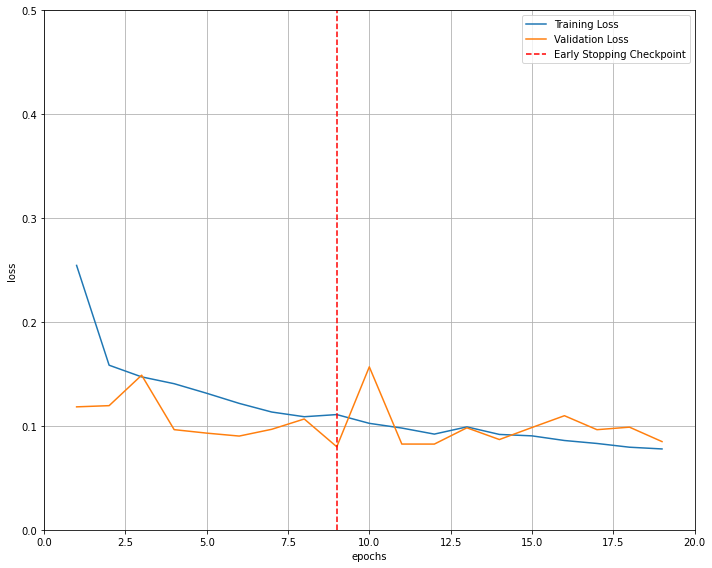

In [ ]:
plot_graph(train_loss, valid_loss)

# Load model


In [ ]:
# load saved model
def load_model(model):
  path = f"/content/drive/MyDrive/CellCount-main/best_model_checkpoints/{model.__class__.__name__}.pth"
  model.load_state_dict(torch.load(path)) 
  model.eval()
  return model

In [ ]:
model = load_model(model)

# Test

In [ ]:
"""
0: black: background
1: red: others (1)
2: green: inflammatory(2)
3: dark blue: healthy epithelial(3) , dysplastic/malignant epithelial(4)
4: light blue: fibroblast(5) , muscle(6) , endothelial(7)
"""
# params: 5 x n x n numpy or n x n x 5
def printColoredMask(npMask,numchannel=5):
    if npMask.shape[-1]!=5:
        npMask=npMask.transpose(1, 2, 0)
    finalnpMask=np.where(npMask[:,:,1]==1,255,0) # one color
    finalnpMask=finalnpMask[:,:,None]
    temp=np.where((npMask[:,:,2]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
    temp=np.where((npMask[:,:,3]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
    plt.imshow(finalnpMask)
    plt.show()

In [ ]:
def test(model, device, data, target):
    print("Input Image")
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    plt.show()
    outputs = model(data.to(device))[0]
    pred = outputs.to('cpu').detach()
    pred=F.softmax(pred, dim=0)# along the channel
    pred=pred.numpy()

    print("Predicted Mask Sigmoid")
    pred[pred.max(axis=0,keepdims=1) == pred] = 1
    pred[pred.max(axis=0,keepdims=1) != pred] = 0
    printColoredMask(pred)
    print("Actual Mask")
    printColoredMask(target[0].numpy())

    # PQ
    pq_score = get_fast_pq(target, pred)[0]
    print("Detection Quality (DQ):", pq_score[0])
    print("Segmentation Quality (SQ):", pq_score[1])
    print("Panoptic Quality (PQ):", pq_score[2])
    
    dice_score = get_dice_1(target, pred)
    print("Dice score:", dice_score, "\n")

Input Image


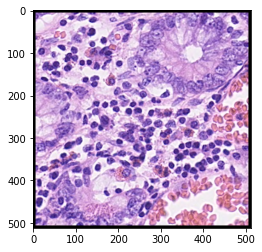

Predicted Mask Sigmoid


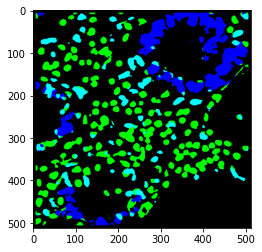

Actual Mask


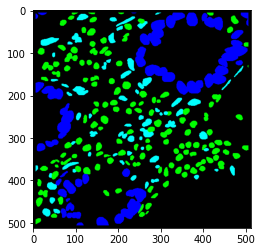

Detection Quality (DQ): 1.0
Segmentation Quality (SQ): 0.7807961975878358
Panoptic Quality (PQ): 0.7807961975878358
Dice score: 0.8769073486328125 



In [ ]:
# Testing the model
for data, target in test_loader:
    test(model, device, data, target)
    break

# Hyperparameter

In [ ]:
def hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name):
    print("Batch size: {}, Learning rate: {} , Epochs: {}\n".format(bs, lr, epochs))
    
    valid_size = 0.2
    batch_size =1

    # DataLoader
    train_data = CellDataset(root_dir=train_dir, transform = transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              sampler=train_sampler,
                              num_workers=0)

    # load validation data in batches
    valid_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              sampler=valid_sampler,
                              num_workers=0)
    
    # Set cpu / gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model and optimizer
    model = build_model(device, "resnet")
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    
    # Train model
    model, train_loss, valid_loss, valid_acc = train(model, device, train_loader, valid_loader, optimizer, epochs, patience, model_chkpt_name)
    plot_graph(train_loss, valid_loss)
    
    print("Dice2 score:", valid_acc)

#### model(2layer) - 500x500 images

In [ ]:
n_bs = [1]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_500"
model_chkpt_name = "ResNet-500x500_2layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

In [ ]:
n_bs = [4]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_500"
model_chkpt_name = "ResNet-500x500_2layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

In [ ]:
n_bs = [8]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_500"
model_chkpt_name = "ResNet-500x500_2layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

In [ ]:
n_bs = [16]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_500"
model_chkpt_name = "ResNet-500x500_2layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

#### model(4layer) - 250x250 images

In [ ]:
n_bs = [1]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_250"
model_chkpt_name = "ResNet-250x250_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

In [ ]:
n_bs = [4]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_250"
model_chkpt_name = "ResNet-250x250_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

In [ ]:
n_bs = [8]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_250"
model_chkpt_name = "ResNet-250x250_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

In [ ]:
n_bs = [16]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_250"
model_chkpt_name = "ResNet-250x250_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

#### model(4layer) - 500x500 images

In [ ]:
n_bs = [1]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_500"
model_chkpt_name = "ResNet-500x500_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

In [ ]:
n_bs = [4]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_500"
model_chkpt_name = "ResNet-500x500_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

In [ ]:
n_bs = [8]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_500"
model_chkpt_name = "ResNet-500x500_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

In [ ]:
n_bs = [16]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_500"
model_chkpt_name = "ResNet-500x500_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

#### model(4layer) - 1000x1000 images

Batch size: 1, Learning rate: 0.001 , Epochs: 60



  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validation loss decreased (inf --> 0.247850).  Saving model ...


  2%|▏         | 1/60 [01:10<1:08:58, 70.15s/it]

Train Epoch: 1 @ 12:50:57.001041 - Train Loss: 0.3918 - Valid Loss: 0.2478
Validation loss decreased (0.247850 --> 0.243593).  Saving model ...


  3%|▎         | 2/60 [01:30<53:24, 55.24s/it]  

Train Epoch: 2 @ 12:51:17.464002 - Train Loss: 0.1984 - Valid Loss: 0.2436
Validation loss decreased (0.243593 --> 0.241451).  Saving model ...


  5%|▌         | 3/60 [01:51<42:33, 44.79s/it]

Train Epoch: 3 @ 12:51:37.878620 - Train Loss: 0.1804 - Valid Loss: 0.2415
Validation loss decreased (0.241451 --> 0.227474).  Saving model ...


  7%|▋         | 4/60 [02:11<35:03, 37.56s/it]

Train Epoch: 4 @ 12:51:58.554421 - Train Loss: 0.1542 - Valid Loss: 0.2275
EarlyStopping counter: 1 out of 10


  8%|▊         | 5/60 [02:32<29:52, 32.60s/it]

Train Epoch: 5 @ 12:52:19.568143 - Train Loss: 0.1539 - Valid Loss: 0.2330
Validation loss decreased (0.227474 --> 0.209857).  Saving model ...


 10%|█         | 6/60 [02:53<26:06, 29.00s/it]

Train Epoch: 6 @ 12:52:40.195822 - Train Loss: 0.1578 - Valid Loss: 0.2099
EarlyStopping counter: 1 out of 10


 12%|█▏        | 7/60 [03:13<23:18, 26.39s/it]

Train Epoch: 7 @ 12:53:00.497431 - Train Loss: 0.1385 - Valid Loss: 0.2228
Validation loss decreased (0.209857 --> 0.206057).  Saving model ...


 13%|█▎        | 8/60 [03:34<21:28, 24.79s/it]

Train Epoch: 8 @ 12:53:21.534543 - Train Loss: 0.1334 - Valid Loss: 0.2061
EarlyStopping counter: 1 out of 10


 15%|█▌        | 9/60 [03:55<20:00, 23.55s/it]

Train Epoch: 9 @ 12:53:42.187373 - Train Loss: 0.1304 - Valid Loss: 0.2114
Validation loss decreased (0.206057 --> 0.189823).  Saving model ...


 17%|█▋        | 10/60 [04:16<19:00, 22.82s/it]

Train Epoch: 10 @ 12:54:03.305457 - Train Loss: 0.1275 - Valid Loss: 0.1898
EarlyStopping counter: 1 out of 10


 18%|█▊        | 11/60 [04:37<18:05, 22.16s/it]

Train Epoch: 11 @ 12:54:23.916726 - Train Loss: 0.1281 - Valid Loss: 0.1975
EarlyStopping counter: 2 out of 10


 20%|██        | 12/60 [04:57<17:21, 21.70s/it]

Train Epoch: 12 @ 12:54:44.564927 - Train Loss: 0.1301 - Valid Loss: 0.2086
Validation loss decreased (0.189823 --> 0.184375).  Saving model ...


 22%|██▏       | 13/60 [05:18<16:53, 21.56s/it]

Train Epoch: 13 @ 12:55:05.775068 - Train Loss: 0.1230 - Valid Loss: 0.1844
Validation loss decreased (0.184375 --> 0.180847).  Saving model ...


 23%|██▎       | 14/60 [05:40<16:29, 21.50s/it]

Train Epoch: 14 @ 12:55:27.152437 - Train Loss: 0.1199 - Valid Loss: 0.1808
EarlyStopping counter: 1 out of 10


 25%|██▌       | 15/60 [06:00<15:56, 21.26s/it]

Train Epoch: 15 @ 12:55:47.835901 - Train Loss: 0.1177 - Valid Loss: 0.1865
Validation loss decreased (0.180847 --> 0.174883).  Saving model ...


 27%|██▋       | 16/60 [06:22<15:36, 21.29s/it]

Train Epoch: 16 @ 12:56:09.196158 - Train Loss: 0.1158 - Valid Loss: 0.1749
Validation loss decreased (0.174883 --> 0.170331).  Saving model ...


 28%|██▊       | 17/60 [06:43<15:14, 21.27s/it]

Train Epoch: 17 @ 12:56:30.434798 - Train Loss: 0.1159 - Valid Loss: 0.1703
EarlyStopping counter: 1 out of 10


 30%|███       | 18/60 [07:04<14:45, 21.07s/it]

Train Epoch: 18 @ 12:56:51.041644 - Train Loss: 0.1127 - Valid Loss: 0.1707
Validation loss decreased (0.170331 --> 0.157943).  Saving model ...


 32%|███▏      | 19/60 [07:25<14:28, 21.18s/it]

Train Epoch: 19 @ 12:57:12.460630 - Train Loss: 0.1112 - Valid Loss: 0.1579
EarlyStopping counter: 1 out of 10


 33%|███▎      | 20/60 [07:46<14:00, 21.01s/it]

Train Epoch: 20 @ 12:57:33.096068 - Train Loss: 0.1079 - Valid Loss: 0.1843
EarlyStopping counter: 2 out of 10


 35%|███▌      | 21/60 [08:06<13:34, 20.88s/it]

Train Epoch: 21 @ 12:57:53.658416 - Train Loss: 0.1083 - Valid Loss: 0.1737
EarlyStopping counter: 3 out of 10


 37%|███▋      | 22/60 [08:27<13:14, 20.91s/it]

Train Epoch: 22 @ 12:58:14.624832 - Train Loss: 0.1036 - Valid Loss: 0.1886
EarlyStopping counter: 4 out of 10


 38%|███▊      | 23/60 [08:48<12:52, 20.89s/it]

Train Epoch: 23 @ 12:58:35.483317 - Train Loss: 0.1091 - Valid Loss: 0.2149
Validation loss decreased (0.157943 --> 0.156484).  Saving model ...


 40%|████      | 24/60 [09:09<12:36, 21.01s/it]

Train Epoch: 24 @ 12:58:56.771069 - Train Loss: 0.1036 - Valid Loss: 0.1565
EarlyStopping counter: 1 out of 10


 42%|████▏     | 25/60 [09:30<12:12, 20.92s/it]

Train Epoch: 25 @ 12:59:17.468749 - Train Loss: 0.0999 - Valid Loss: 0.1786
EarlyStopping counter: 2 out of 10


 43%|████▎     | 26/60 [09:51<11:48, 20.84s/it]

Train Epoch: 26 @ 12:59:38.118469 - Train Loss: 0.0976 - Valid Loss: 0.1973
Validation loss decreased (0.156484 --> 0.156028).  Saving model ...


 45%|████▌     | 27/60 [10:12<11:32, 21.00s/it]

Train Epoch: 27 @ 12:59:59.498391 - Train Loss: 0.0954 - Valid Loss: 0.1560
EarlyStopping counter: 1 out of 10


 47%|████▋     | 28/60 [10:33<11:08, 20.89s/it]

Train Epoch: 28 @ 13:00:20.120938 - Train Loss: 0.0982 - Valid Loss: 0.2254
EarlyStopping counter: 2 out of 10


 48%|████▊     | 29/60 [10:53<10:44, 20.80s/it]

Train Epoch: 29 @ 13:00:40.706421 - Train Loss: 0.0921 - Valid Loss: 0.2090
EarlyStopping counter: 3 out of 10


 50%|█████     | 30/60 [11:14<10:24, 20.82s/it]

Train Epoch: 30 @ 13:01:01.598324 - Train Loss: 0.0956 - Valid Loss: 0.1627
Validation loss decreased (0.156028 --> 0.152440).  Saving model ...


 52%|█████▏    | 31/60 [11:35<10:06, 20.91s/it]

Train Epoch: 31 @ 13:01:22.712937 - Train Loss: 0.0922 - Valid Loss: 0.1524
EarlyStopping counter: 1 out of 10


 53%|█████▎    | 32/60 [11:56<09:42, 20.81s/it]

Train Epoch: 32 @ 13:01:43.292114 - Train Loss: 0.1031 - Valid Loss: 0.1970
EarlyStopping counter: 2 out of 10


 55%|█████▌    | 33/60 [12:17<09:20, 20.76s/it]

Train Epoch: 33 @ 13:02:03.939073 - Train Loss: 0.0858 - Valid Loss: 0.2881
EarlyStopping counter: 3 out of 10


 57%|█████▋    | 34/60 [12:37<08:58, 20.71s/it]

Train Epoch: 34 @ 13:02:24.515981 - Train Loss: 0.0843 - Valid Loss: 0.1801
EarlyStopping counter: 4 out of 10


 58%|█████▊    | 35/60 [12:58<08:35, 20.62s/it]

Train Epoch: 35 @ 13:02:44.921333 - Train Loss: 0.0781 - Valid Loss: 0.1731
Validation loss decreased (0.152440 --> 0.152371).  Saving model ...


 60%|██████    | 36/60 [13:19<08:18, 20.77s/it]

Train Epoch: 36 @ 13:03:06.033624 - Train Loss: 0.0760 - Valid Loss: 0.1524
EarlyStopping counter: 1 out of 10


 62%|██████▏   | 37/60 [13:39<07:56, 20.71s/it]

Train Epoch: 37 @ 13:03:26.613097 - Train Loss: 0.0761 - Valid Loss: 0.1827
EarlyStopping counter: 2 out of 10


 63%|██████▎   | 38/60 [14:00<07:37, 20.79s/it]

Train Epoch: 38 @ 13:03:47.585997 - Train Loss: 0.0803 - Valid Loss: 0.2392
EarlyStopping counter: 3 out of 10


 65%|██████▌   | 39/60 [14:21<07:15, 20.72s/it]

Train Epoch: 39 @ 13:04:08.158700 - Train Loss: 0.0740 - Valid Loss: 0.2212
Validation loss decreased (0.152371 --> 0.147402).  Saving model ...


 67%|██████▋   | 40/60 [14:44<07:09, 21.46s/it]

Train Epoch: 40 @ 13:04:31.325755 - Train Loss: 0.0714 - Valid Loss: 0.1474
EarlyStopping counter: 1 out of 10


 68%|██████▊   | 41/60 [15:05<06:43, 21.26s/it]

Train Epoch: 41 @ 13:04:52.110744 - Train Loss: 0.0729 - Valid Loss: 0.2038
Validation loss decreased (0.147402 --> 0.133423).  Saving model ...


 70%|███████   | 42/60 [15:26<06:21, 21.20s/it]

Train Epoch: 42 @ 13:05:13.189419 - Train Loss: 0.0692 - Valid Loss: 0.1334
EarlyStopping counter: 1 out of 10


 72%|███████▏  | 43/60 [15:46<05:56, 20.99s/it]

Train Epoch: 43 @ 13:05:33.691959 - Train Loss: 0.0655 - Valid Loss: 0.1394
EarlyStopping counter: 2 out of 10


 73%|███████▎  | 44/60 [16:08<05:38, 21.13s/it]

Train Epoch: 44 @ 13:05:55.147001 - Train Loss: 0.0659 - Valid Loss: 0.2587
EarlyStopping counter: 3 out of 10


 75%|███████▌  | 45/60 [16:28<05:14, 20.96s/it]

Train Epoch: 45 @ 13:06:15.711777 - Train Loss: 0.0656 - Valid Loss: 0.2358
EarlyStopping counter: 4 out of 10


 77%|███████▋  | 46/60 [16:49<04:51, 20.83s/it]

Train Epoch: 46 @ 13:06:36.224781 - Train Loss: 0.0633 - Valid Loss: 0.1636
EarlyStopping counter: 5 out of 10


 78%|███████▊  | 47/60 [17:10<04:30, 20.78s/it]

Train Epoch: 47 @ 13:06:56.903516 - Train Loss: 0.0613 - Valid Loss: 0.1518
EarlyStopping counter: 6 out of 10


 80%|████████  | 48/60 [17:30<04:09, 20.80s/it]

Train Epoch: 48 @ 13:07:17.754927 - Train Loss: 0.0587 - Valid Loss: 0.1753
EarlyStopping counter: 7 out of 10


 82%|████████▏ | 49/60 [17:51<03:48, 20.75s/it]

Train Epoch: 49 @ 13:07:38.367194 - Train Loss: 0.0581 - Valid Loss: 0.2252
EarlyStopping counter: 8 out of 10


 83%|████████▎ | 50/60 [18:12<03:27, 20.79s/it]

Train Epoch: 50 @ 13:07:59.261253 - Train Loss: 0.0626 - Valid Loss: 0.1522
EarlyStopping counter: 9 out of 10


 85%|████████▌ | 51/60 [18:33<03:06, 20.77s/it]

Train Epoch: 51 @ 13:08:19.978097 - Train Loss: 0.0597 - Valid Loss: 0.1449
EarlyStopping counter: 10 out of 10
Early stopping


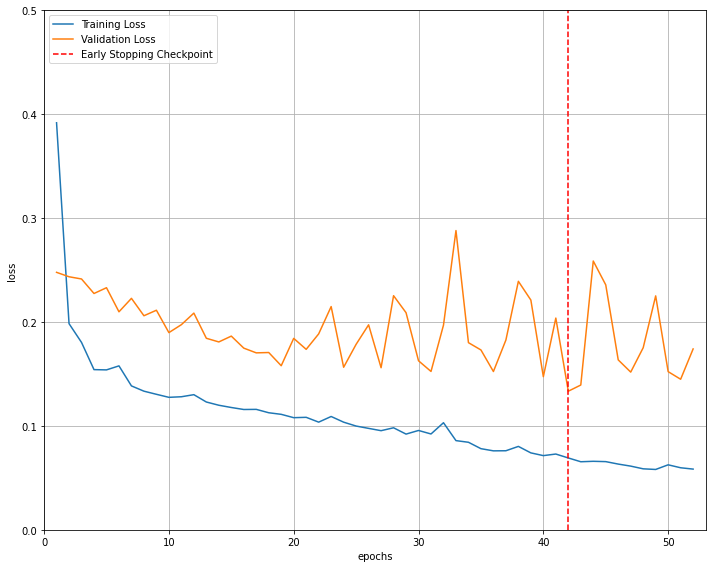

Dice2 score: 0.8904138565063476
Batch size: 1, Learning rate: 0.0001 , Epochs: 60




  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.204520).  Saving model ...



  2%|▏         | 1/60 [00:21<21:19, 21.68s/it]

Train Epoch: 1 @ 13:09:03.330579 - Train Loss: 0.4006 - Valid Loss: 0.2045
Validation loss decreased (0.204520 --> 0.138960).  Saving model ...



  3%|▎         | 2/60 [00:43<20:58, 21.69s/it]

Train Epoch: 2 @ 13:09:25.040499 - Train Loss: 0.2795 - Valid Loss: 0.1390
Validation loss decreased (0.138960 --> 0.130234).  Saving model ...



  5%|▌         | 3/60 [01:05<20:35, 21.68s/it]

Train Epoch: 3 @ 13:09:46.680198 - Train Loss: 0.2525 - Valid Loss: 0.1302
Validation loss decreased (0.130234 --> 0.122956).  Saving model ...



  7%|▋         | 4/60 [01:27<20:25, 21.89s/it]

Train Epoch: 4 @ 13:10:09.068185 - Train Loss: 0.2219 - Valid Loss: 0.1230
Validation loss decreased (0.122956 --> 0.118822).  Saving model ...



  8%|▊         | 5/60 [01:48<19:57, 21.78s/it]

Train Epoch: 5 @ 13:10:30.592926 - Train Loss: 0.1970 - Valid Loss: 0.1188
Validation loss decreased (0.118822 --> 0.108706).  Saving model ...



 10%|█         | 6/60 [02:10<19:35, 21.77s/it]

Train Epoch: 6 @ 13:10:52.337250 - Train Loss: 0.1794 - Valid Loss: 0.1087
Validation loss decreased (0.108706 --> 0.106169).  Saving model ...



 12%|█▏        | 7/60 [02:32<19:13, 21.77s/it]

Train Epoch: 7 @ 13:11:14.115913 - Train Loss: 0.1640 - Valid Loss: 0.1062
Validation loss decreased (0.106169 --> 0.102184).  Saving model ...



 13%|█▎        | 8/60 [02:55<19:18, 22.29s/it]

Train Epoch: 8 @ 13:11:37.603104 - Train Loss: 0.1612 - Valid Loss: 0.1022
Validation loss decreased (0.102184 --> 0.097172).  Saving model ...



 15%|█▌        | 9/60 [03:17<18:52, 22.21s/it]

Train Epoch: 9 @ 13:11:59.624149 - Train Loss: 0.1475 - Valid Loss: 0.0972
Validation loss decreased (0.097172 --> 0.092754).  Saving model ...



 17%|█▋        | 10/60 [03:39<18:25, 22.11s/it]

Train Epoch: 10 @ 13:12:21.511867 - Train Loss: 0.1361 - Valid Loss: 0.0928
EarlyStopping counter: 1 out of 10



 18%|█▊        | 11/60 [04:01<17:51, 21.86s/it]

Train Epoch: 11 @ 13:12:42.783529 - Train Loss: 0.1343 - Valid Loss: 0.0968
Validation loss decreased (0.092754 --> 0.087328).  Saving model ...



 20%|██        | 12/60 [04:23<17:33, 21.94s/it]

Train Epoch: 12 @ 13:13:04.880749 - Train Loss: 0.1253 - Valid Loss: 0.0873
EarlyStopping counter: 1 out of 10



 22%|██▏       | 13/60 [04:44<17:02, 21.76s/it]

Train Epoch: 13 @ 13:13:26.249203 - Train Loss: 0.1191 - Valid Loss: 0.0901
Validation loss decreased (0.087328 --> 0.081575).  Saving model ...



 23%|██▎       | 14/60 [05:06<16:41, 21.78s/it]

Train Epoch: 14 @ 13:13:48.069328 - Train Loss: 0.1151 - Valid Loss: 0.0816
EarlyStopping counter: 1 out of 10



 25%|██▌       | 15/60 [05:28<16:17, 21.71s/it]

Train Epoch: 15 @ 13:14:09.630556 - Train Loss: 0.1134 - Valid Loss: 0.0860
Validation loss decreased (0.081575 --> 0.080117).  Saving model ...



 27%|██▋       | 16/60 [05:50<16:01, 21.84s/it]

Train Epoch: 16 @ 13:14:31.773049 - Train Loss: 0.1093 - Valid Loss: 0.0801
Validation loss decreased (0.080117 --> 0.080007).  Saving model ...



 28%|██▊       | 17/60 [06:12<15:41, 21.90s/it]

Train Epoch: 17 @ 13:14:53.803022 - Train Loss: 0.1032 - Valid Loss: 0.0800
EarlyStopping counter: 1 out of 10



 30%|███       | 18/60 [06:33<15:11, 21.71s/it]

Train Epoch: 18 @ 13:15:15.074450 - Train Loss: 0.0996 - Valid Loss: 0.0816
EarlyStopping counter: 2 out of 10



 32%|███▏      | 19/60 [06:54<14:46, 21.61s/it]

Train Epoch: 19 @ 13:15:36.453683 - Train Loss: 0.0982 - Valid Loss: 0.0813
Validation loss decreased (0.080007 --> 0.077926).  Saving model ...



 33%|███▎      | 20/60 [07:16<14:31, 21.78s/it]

Train Epoch: 20 @ 13:15:58.613997 - Train Loss: 0.0955 - Valid Loss: 0.0779
EarlyStopping counter: 1 out of 10



 35%|███▌      | 21/60 [07:38<14:04, 21.65s/it]

Train Epoch: 21 @ 13:16:19.970800 - Train Loss: 0.0946 - Valid Loss: 0.0854
EarlyStopping counter: 2 out of 10



 37%|███▋      | 22/60 [07:59<13:39, 21.57s/it]

Train Epoch: 22 @ 13:16:41.338445 - Train Loss: 0.0955 - Valid Loss: 0.0786
EarlyStopping counter: 3 out of 10



 38%|███▊      | 23/60 [08:21<13:17, 21.54s/it]

Train Epoch: 23 @ 13:17:02.820594 - Train Loss: 0.0973 - Valid Loss: 0.0917
EarlyStopping counter: 4 out of 10



 40%|████      | 24/60 [08:42<12:52, 21.44s/it]

Train Epoch: 24 @ 13:17:24.041896 - Train Loss: 0.1069 - Valid Loss: 0.0796
Validation loss decreased (0.077926 --> 0.075441).  Saving model ...



 42%|████▏     | 25/60 [09:04<12:33, 21.54s/it]

Train Epoch: 25 @ 13:17:45.798332 - Train Loss: 0.0979 - Valid Loss: 0.0754
EarlyStopping counter: 1 out of 10



 43%|████▎     | 26/60 [09:26<12:23, 21.87s/it]

Train Epoch: 26 @ 13:18:08.436308 - Train Loss: 0.0910 - Valid Loss: 0.0766
Validation loss decreased (0.075441 --> 0.073821).  Saving model ...



 45%|████▌     | 27/60 [09:48<12:00, 21.83s/it]

Train Epoch: 27 @ 13:18:30.176260 - Train Loss: 0.0813 - Valid Loss: 0.0738
Validation loss decreased (0.073821 --> 0.072945).  Saving model ...



 47%|████▋     | 28/60 [10:10<11:39, 21.86s/it]

Train Epoch: 28 @ 13:18:52.096817 - Train Loss: 0.0759 - Valid Loss: 0.0729
Validation loss decreased (0.072945 --> 0.071059).  Saving model ...



 48%|████▊     | 29/60 [10:32<11:19, 21.91s/it]

Train Epoch: 29 @ 13:19:14.135339 - Train Loss: 0.0725 - Valid Loss: 0.0711
EarlyStopping counter: 1 out of 10



 50%|█████     | 30/60 [10:53<10:52, 21.74s/it]

Train Epoch: 30 @ 13:19:35.481871 - Train Loss: 0.0734 - Valid Loss: 0.0797
EarlyStopping counter: 2 out of 10



 52%|█████▏    | 31/60 [11:15<10:26, 21.60s/it]

Train Epoch: 31 @ 13:19:56.749393 - Train Loss: 0.0711 - Valid Loss: 0.0761
EarlyStopping counter: 3 out of 10



 53%|█████▎    | 32/60 [11:36<10:05, 21.62s/it]

Train Epoch: 32 @ 13:20:18.416518 - Train Loss: 0.0684 - Valid Loss: 0.0754
EarlyStopping counter: 4 out of 10



 55%|█████▌    | 33/60 [11:58<09:42, 21.56s/it]

Train Epoch: 33 @ 13:20:39.854327 - Train Loss: 0.0677 - Valid Loss: 0.0748
EarlyStopping counter: 5 out of 10



 57%|█████▋    | 34/60 [12:19<09:20, 21.54s/it]

Train Epoch: 34 @ 13:21:01.337093 - Train Loss: 0.0650 - Valid Loss: 0.0724
EarlyStopping counter: 6 out of 10



 58%|█████▊    | 35/60 [12:40<08:56, 21.46s/it]

Train Epoch: 35 @ 13:21:22.619787 - Train Loss: 0.0673 - Valid Loss: 0.0738
EarlyStopping counter: 7 out of 10



 60%|██████    | 36/60 [13:02<08:35, 21.46s/it]

Train Epoch: 36 @ 13:21:44.071230 - Train Loss: 0.0657 - Valid Loss: 0.0735
EarlyStopping counter: 8 out of 10



 62%|██████▏   | 37/60 [13:24<08:14, 21.51s/it]

Train Epoch: 37 @ 13:22:05.693374 - Train Loss: 0.0645 - Valid Loss: 0.0791
EarlyStopping counter: 9 out of 10



 63%|██████▎   | 38/60 [13:46<07:58, 21.77s/it]

Train Epoch: 38 @ 13:22:28.081597 - Train Loss: 0.0642 - Valid Loss: 0.0727
EarlyStopping counter: 10 out of 10
Early stopping


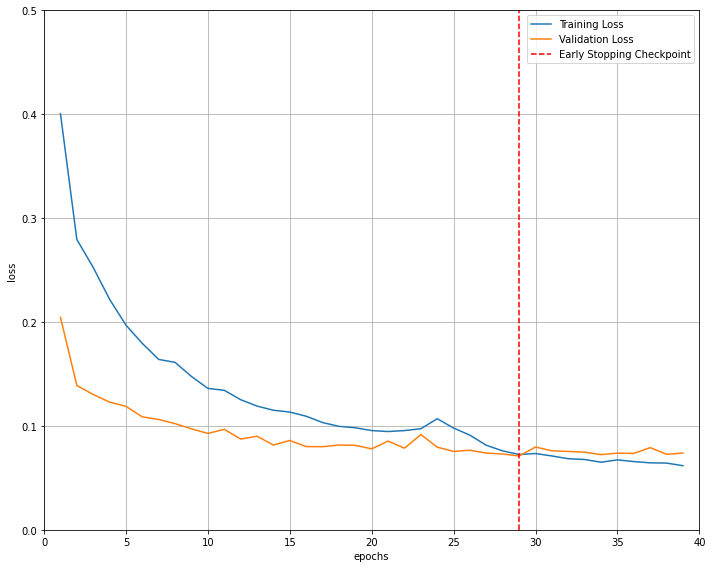

Dice2 score: 0.9395395278930664
Batch size: 1, Learning rate: 1e-05 , Epochs: 60





  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.637599).  Saving model ...




  2%|▏         | 1/60 [00:22<21:39, 22.02s/it]

Train Epoch: 1 @ 13:23:12.550746 - Train Loss: 0.6752 - Valid Loss: 0.6376
Validation loss decreased (0.637599 --> 0.375606).  Saving model ...




  3%|▎         | 2/60 [00:43<21:11, 21.93s/it]

Train Epoch: 2 @ 13:23:34.261487 - Train Loss: 0.4628 - Valid Loss: 0.3756
Validation loss decreased (0.375606 --> 0.351827).  Saving model ...




  5%|▌         | 3/60 [01:05<20:49, 21.92s/it]

Train Epoch: 3 @ 13:23:56.167403 - Train Loss: 0.2866 - Valid Loss: 0.3518
Validation loss decreased (0.351827 --> 0.348329).  Saving model ...




  7%|▋         | 4/60 [01:29<21:02, 22.55s/it]

Train Epoch: 4 @ 13:24:20.166932 - Train Loss: 0.2599 - Valid Loss: 0.3483
Validation loss decreased (0.348329 --> 0.347269).  Saving model ...




  8%|▊         | 5/60 [01:51<20:27, 22.33s/it]

Train Epoch: 5 @ 13:24:41.979281 - Train Loss: 0.2466 - Valid Loss: 0.3473
Validation loss decreased (0.347269 --> 0.345517).  Saving model ...




 10%|█         | 6/60 [02:13<20:02, 22.26s/it]

Train Epoch: 6 @ 13:25:04.090933 - Train Loss: 0.2389 - Valid Loss: 0.3455
EarlyStopping counter: 1 out of 10




 12%|█▏        | 7/60 [02:35<19:27, 22.03s/it]

Train Epoch: 7 @ 13:25:25.588206 - Train Loss: 0.2312 - Valid Loss: 0.3461
EarlyStopping counter: 2 out of 10




 13%|█▎        | 8/60 [02:56<18:58, 21.89s/it]

Train Epoch: 8 @ 13:25:47.142635 - Train Loss: 0.2259 - Valid Loss: 0.3463
Validation loss decreased (0.345517 --> 0.343621).  Saving model ...




 15%|█▌        | 9/60 [03:18<18:37, 21.91s/it]

Train Epoch: 9 @ 13:26:09.098421 - Train Loss: 0.2200 - Valid Loss: 0.3436
Validation loss decreased (0.343621 --> 0.343195).  Saving model ...




 17%|█▋        | 10/60 [03:40<18:15, 21.91s/it]

Train Epoch: 10 @ 13:26:31.005197 - Train Loss: 0.2153 - Valid Loss: 0.3432
Validation loss decreased (0.343195 --> 0.341165).  Saving model ...




 18%|█▊        | 11/60 [04:02<17:56, 21.96s/it]

Train Epoch: 11 @ 13:26:53.085486 - Train Loss: 0.2115 - Valid Loss: 0.3412
Validation loss decreased (0.341165 --> 0.339880).  Saving model ...




 20%|██        | 12/60 [04:26<17:55, 22.41s/it]

Train Epoch: 12 @ 13:27:16.562598 - Train Loss: 0.2073 - Valid Loss: 0.3399
Validation loss decreased (0.339880 --> 0.337882).  Saving model ...




 22%|██▏       | 13/60 [04:47<17:25, 22.24s/it]

Train Epoch: 13 @ 13:27:38.395296 - Train Loss: 0.2035 - Valid Loss: 0.3379
Validation loss decreased (0.337882 --> 0.337019).  Saving model ...




 23%|██▎       | 14/60 [05:09<17:00, 22.19s/it]

Train Epoch: 14 @ 13:28:00.469304 - Train Loss: 0.2000 - Valid Loss: 0.3370
Validation loss decreased (0.337019 --> 0.333537).  Saving model ...




 25%|██▌       | 15/60 [05:31<16:34, 22.09s/it]

Train Epoch: 15 @ 13:28:22.329824 - Train Loss: 0.1956 - Valid Loss: 0.3335
Validation loss decreased (0.333537 --> 0.330072).  Saving model ...




 27%|██▋       | 16/60 [05:57<16:57, 23.12s/it]

Train Epoch: 16 @ 13:28:47.856400 - Train Loss: 0.1905 - Valid Loss: 0.3301
Validation loss decreased (0.330072 --> 0.326843).  Saving model ...




 28%|██▊       | 17/60 [06:19<16:21, 22.82s/it]

Train Epoch: 17 @ 13:29:09.980830 - Train Loss: 0.1865 - Valid Loss: 0.3268
Validation loss decreased (0.326843 --> 0.324398).  Saving model ...




 30%|███       | 18/60 [06:41<15:46, 22.54s/it]

Train Epoch: 18 @ 13:29:31.870093 - Train Loss: 0.1816 - Valid Loss: 0.3244
Validation loss decreased (0.324398 --> 0.321168).  Saving model ...




 32%|███▏      | 19/60 [07:03<15:15, 22.34s/it]

Train Epoch: 19 @ 13:29:53.723685 - Train Loss: 0.1769 - Valid Loss: 0.3212
Validation loss decreased (0.321168 --> 0.317659).  Saving model ...




 33%|███▎      | 20/60 [07:25<14:49, 22.24s/it]

Train Epoch: 20 @ 13:30:15.743932 - Train Loss: 0.1730 - Valid Loss: 0.3177
Validation loss decreased (0.317659 --> 0.313151).  Saving model ...




 35%|███▌      | 21/60 [07:46<14:22, 22.10s/it]

Train Epoch: 21 @ 13:30:37.526366 - Train Loss: 0.1692 - Valid Loss: 0.3132
Validation loss decreased (0.313151 --> 0.308817).  Saving model ...




 37%|███▋      | 22/60 [08:08<13:55, 21.98s/it]

Train Epoch: 22 @ 13:30:59.231863 - Train Loss: 0.1654 - Valid Loss: 0.3088
Validation loss decreased (0.308817 --> 0.304091).  Saving model ...




 38%|███▊      | 23/60 [08:30<13:33, 21.97s/it]

Train Epoch: 23 @ 13:31:21.185437 - Train Loss: 0.1614 - Valid Loss: 0.3041
Validation loss decreased (0.304091 --> 0.301570).  Saving model ...




 40%|████      | 24/60 [08:52<13:11, 21.98s/it]

Train Epoch: 24 @ 13:31:43.166040 - Train Loss: 0.1572 - Valid Loss: 0.3016
Validation loss decreased (0.301570 --> 0.300036).  Saving model ...




 42%|████▏     | 25/60 [09:14<12:47, 21.93s/it]

Train Epoch: 25 @ 13:32:04.997890 - Train Loss: 0.1537 - Valid Loss: 0.3000
Validation loss decreased (0.300036 --> 0.292066).  Saving model ...




 43%|████▎     | 26/60 [09:36<12:23, 21.86s/it]

Train Epoch: 26 @ 13:32:26.682134 - Train Loss: 0.1500 - Valid Loss: 0.2921
EarlyStopping counter: 1 out of 10




 45%|████▌     | 27/60 [09:58<12:05, 21.97s/it]

Train Epoch: 27 @ 13:32:48.911358 - Train Loss: 0.1467 - Valid Loss: 0.2924
Validation loss decreased (0.292066 --> 0.288165).  Saving model ...




 47%|████▋     | 28/60 [10:20<11:42, 21.94s/it]

Train Epoch: 28 @ 13:33:10.793667 - Train Loss: 0.1433 - Valid Loss: 0.2882
Validation loss decreased (0.288165 --> 0.284975).  Saving model ...




 48%|████▊     | 29/60 [10:41<11:17, 21.86s/it]

Train Epoch: 29 @ 13:33:32.455667 - Train Loss: 0.1418 - Valid Loss: 0.2850
Validation loss decreased (0.284975 --> 0.268583).  Saving model ...




 50%|█████     | 30/60 [11:03<10:56, 21.87s/it]

Train Epoch: 30 @ 13:33:54.353389 - Train Loss: 0.1407 - Valid Loss: 0.2686
EarlyStopping counter: 1 out of 10




 52%|█████▏    | 31/60 [11:25<10:29, 21.71s/it]

Train Epoch: 31 @ 13:34:15.676894 - Train Loss: 0.1397 - Valid Loss: 0.2700
Validation loss decreased (0.268583 --> 0.263704).  Saving model ...




 53%|█████▎    | 32/60 [11:46<10:08, 21.73s/it]

Train Epoch: 32 @ 13:34:37.468128 - Train Loss: 0.1368 - Valid Loss: 0.2637
EarlyStopping counter: 1 out of 10




 55%|█████▌    | 33/60 [12:08<09:44, 21.63s/it]

Train Epoch: 33 @ 13:34:58.863909 - Train Loss: 0.1329 - Valid Loss: 0.2640
Validation loss decreased (0.263704 --> 0.257497).  Saving model ...




 57%|█████▋    | 34/60 [12:30<09:24, 21.71s/it]

Train Epoch: 34 @ 13:35:20.767836 - Train Loss: 0.1299 - Valid Loss: 0.2575
EarlyStopping counter: 1 out of 10




 58%|█████▊    | 35/60 [12:51<09:01, 21.68s/it]

Train Epoch: 35 @ 13:35:42.360072 - Train Loss: 0.1274 - Valid Loss: 0.2581
Validation loss decreased (0.257497 --> 0.256180).  Saving model ...




 60%|██████    | 36/60 [13:13<08:42, 21.76s/it]

Train Epoch: 36 @ 13:36:04.310176 - Train Loss: 0.1251 - Valid Loss: 0.2562
EarlyStopping counter: 1 out of 10




 62%|██████▏   | 37/60 [13:35<08:18, 21.65s/it]

Train Epoch: 37 @ 13:36:25.720705 - Train Loss: 0.1227 - Valid Loss: 0.2604
Validation loss decreased (0.256180 --> 0.249578).  Saving model ...




 63%|██████▎   | 38/60 [13:57<07:59, 21.81s/it]

Train Epoch: 38 @ 13:36:47.888845 - Train Loss: 0.1196 - Valid Loss: 0.2496
EarlyStopping counter: 1 out of 10




 65%|██████▌   | 39/60 [14:18<07:35, 21.68s/it]

Train Epoch: 39 @ 13:37:09.263765 - Train Loss: 0.1169 - Valid Loss: 0.2659
EarlyStopping counter: 2 out of 10




 67%|██████▋   | 40/60 [14:40<07:11, 21.56s/it]

Train Epoch: 40 @ 13:37:30.559427 - Train Loss: 0.1147 - Valid Loss: 0.2564
EarlyStopping counter: 3 out of 10




 68%|██████▊   | 41/60 [15:01<06:49, 21.57s/it]

Train Epoch: 41 @ 13:37:52.138432 - Train Loss: 0.1117 - Valid Loss: 0.2698
Validation loss decreased (0.249578 --> 0.246643).  Saving model ...




 70%|███████   | 42/60 [15:23<06:29, 21.66s/it]

Train Epoch: 42 @ 13:38:14.015974 - Train Loss: 0.1094 - Valid Loss: 0.2466
EarlyStopping counter: 1 out of 10




 72%|███████▏  | 43/60 [15:44<06:06, 21.55s/it]

Train Epoch: 43 @ 13:38:35.305398 - Train Loss: 0.1083 - Valid Loss: 0.2558
EarlyStopping counter: 2 out of 10




 73%|███████▎  | 44/60 [16:06<05:45, 21.56s/it]

Train Epoch: 44 @ 13:38:56.904734 - Train Loss: 0.1059 - Valid Loss: 0.2546
EarlyStopping counter: 3 out of 10




 75%|███████▌  | 45/60 [16:27<05:22, 21.51s/it]

Train Epoch: 45 @ 13:39:18.304616 - Train Loss: 0.1030 - Valid Loss: 0.2747
EarlyStopping counter: 4 out of 10




 77%|███████▋  | 46/60 [16:49<05:00, 21.44s/it]

Train Epoch: 46 @ 13:39:39.571106 - Train Loss: 0.1016 - Valid Loss: 0.2603
EarlyStopping counter: 5 out of 10




 78%|███████▊  | 47/60 [17:10<04:38, 21.44s/it]

Train Epoch: 47 @ 13:40:01.014964 - Train Loss: 0.0994 - Valid Loss: 0.2751
EarlyStopping counter: 6 out of 10




 80%|████████  | 48/60 [17:31<04:17, 21.42s/it]

Train Epoch: 48 @ 13:40:22.381010 - Train Loss: 0.0980 - Valid Loss: 0.2503
EarlyStopping counter: 7 out of 10




 82%|████████▏ | 49/60 [17:53<03:55, 21.38s/it]

Train Epoch: 49 @ 13:40:43.658034 - Train Loss: 0.0969 - Valid Loss: 0.2802
EarlyStopping counter: 8 out of 10




 83%|████████▎ | 50/60 [18:14<03:34, 21.42s/it]

Train Epoch: 50 @ 13:41:05.172759 - Train Loss: 0.0960 - Valid Loss: 0.2554
EarlyStopping counter: 9 out of 10




 85%|████████▌ | 51/60 [18:36<03:12, 21.43s/it]

Train Epoch: 51 @ 13:41:26.635744 - Train Loss: 0.0954 - Valid Loss: 0.2671
EarlyStopping counter: 10 out of 10
Early stopping


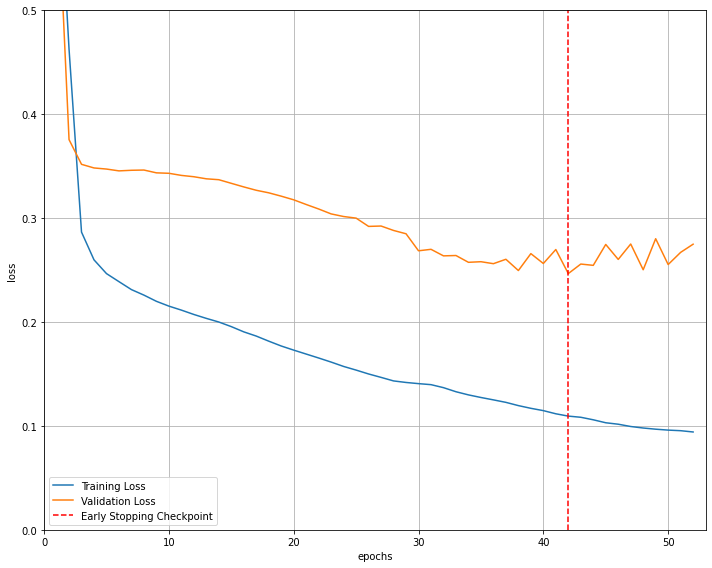

Dice2 score: 0.7982578277587891


In [ ]:
n_bs = [1]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "/content/drive/MyDrive/CellCount-main/Train"
model_chkpt_name = "ResNet-1000x1000_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)